# Durée passée dans chaque lieu selon la plage horaire

## I - Base de données

In [62]:
''' Importation des packages nécessaires '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import scipy.stats
!pip install openpyxl

In [63]:
emp_df=pd.read_excel("data/data.xlsx")
nb_dep_df=emp_df.groupby("IDENT_IND")["num_dep_V"].max().to_frame().rename(columns={"num_dep_V":"nb_dep"})
emp_df=emp_df.set_index("IDENT_IND")
emp_df["nb_dep"]=nb_dep_df["nb_dep"]
emp_df=emp_df.reset_index()
emp_df.head()

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep
0,110000011400001,0,9891.108772,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,Parking,mercredi,14.25,14.333333,2029-01-03 14:15:00,2029-01-03 14:20:00,2.20000,Particulier,Particulier,1,2
1,110000011400001,1,9891.108772,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,mercredi,14.75,14.833333,2029-01-03 14:45:00,2029-01-03 14:50:00,2.20000,Particulier,Particulier,2,2
2,110000011500001,2,5275.295948,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,Parking,vendredi,7.75,8.750000,2029-01-05 07:45:00,2029-01-05 08:45:00,28.00000,Particulier,Particulier,1,2
3,110000011500001,3,5275.295948,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,vendredi,10.50,11.000000,2029-01-05 10:30:00,2029-01-05 11:00:00,28.00000,Particulier,Particulier,2,2
4,110000013500002,4,24058.724023,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,Entreprise,mercredi,15.00,15.250000,2029-01-03 15:00:00,2029-01-03 15:15:00,5.32141,Particulier,Particulier,1,2


In [64]:
data=emp_df
data["Durée"]=0 #On crée une colonne "durée"
data.loc[data["nb_dep"]==1,"Durée"]=24-data["HEURE_ARRIVEE"]
data.loc[data["nb_dep"]==data["num_dep_V"],"Durée"]=24-data["HEURE_ARRIVEE"]
#On remplit la colonne "durée" en faisant la différence entre l'heure du prochain départ de l'individu et l'heure d'arriver à son lieu actuel.
data.loc[(data["nb_dep"]!=1)&(data["nb_dep"]!=data["num_dep_V"]),'Durée'] = data.groupby('IDENT_IND')["HEURE_DEPART"].shift(-1) - data["HEURE_ARRIVEE"]

/tmp/ipykernel_1199/2682466481.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.91666667  4.91666667 13.75       14.66666667 11.5         8.66666667
  0.          6.5         1.5         7.33333333  5.         15.
 10.25       11.         15.          6.5        12.75       15.
 16.66666667  7.         12.25        0.          6.83333333  0.
  6.83333333 10.75       14.93333333  8.75        4.5        13.66666667
 17.33333333  5.16666667 15.25       14.5        12.33333333 13.83333333
  2.5         5.          7.83333333  4.83333333 13.          7.5
 16.91666667 17.08333333  5.          9.25        0.25       10.75
 12.25       11.         15.75        7.5         3.5        10.75
  1.5        15.          7.58333333  4.5         7.75        2.5
  5.5        12.83333333  3.         17.         10.         15.5
  5.          5.25       16.08333333 15.75        8.         14.25
  5.5         8.     

### Séparation de la base de données en 4 plages horaires (pour les heures de départ)

In [65]:
emp_df=data
# Matin (départ entre 00h et 11h) :
emp_matin=emp_df[emp_df["HEURE_DEPART"]<=11]
# Midi (départ entre 11h et 14h) :
emp_midi=emp_df[(emp_df["HEURE_DEPART"]>11)&( emp_df["HEURE_DEPART"]<=14)]
# Après-midi (départ entre 14h et 17h) :
emp_am=emp_df[(emp_df["HEURE_DEPART"]>14)&( emp_df["HEURE_DEPART"]<=17)]
# Soir (départ entre 17h et 00h) :
emp_soir=emp_df[(emp_df["HEURE_DEPART"]>17)&( emp_df["HEURE_DEPART"]<=24)]

#### Remarque : Il y a entre 4000 et 7500 déplacements pour chaque plage horaire.

### Représentation graphique de la durée passée dans chaque lieu pour chaque période de la journée :
    

In [66]:
dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma','loggamma', 'invgauss', 'chi2']

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le matin')

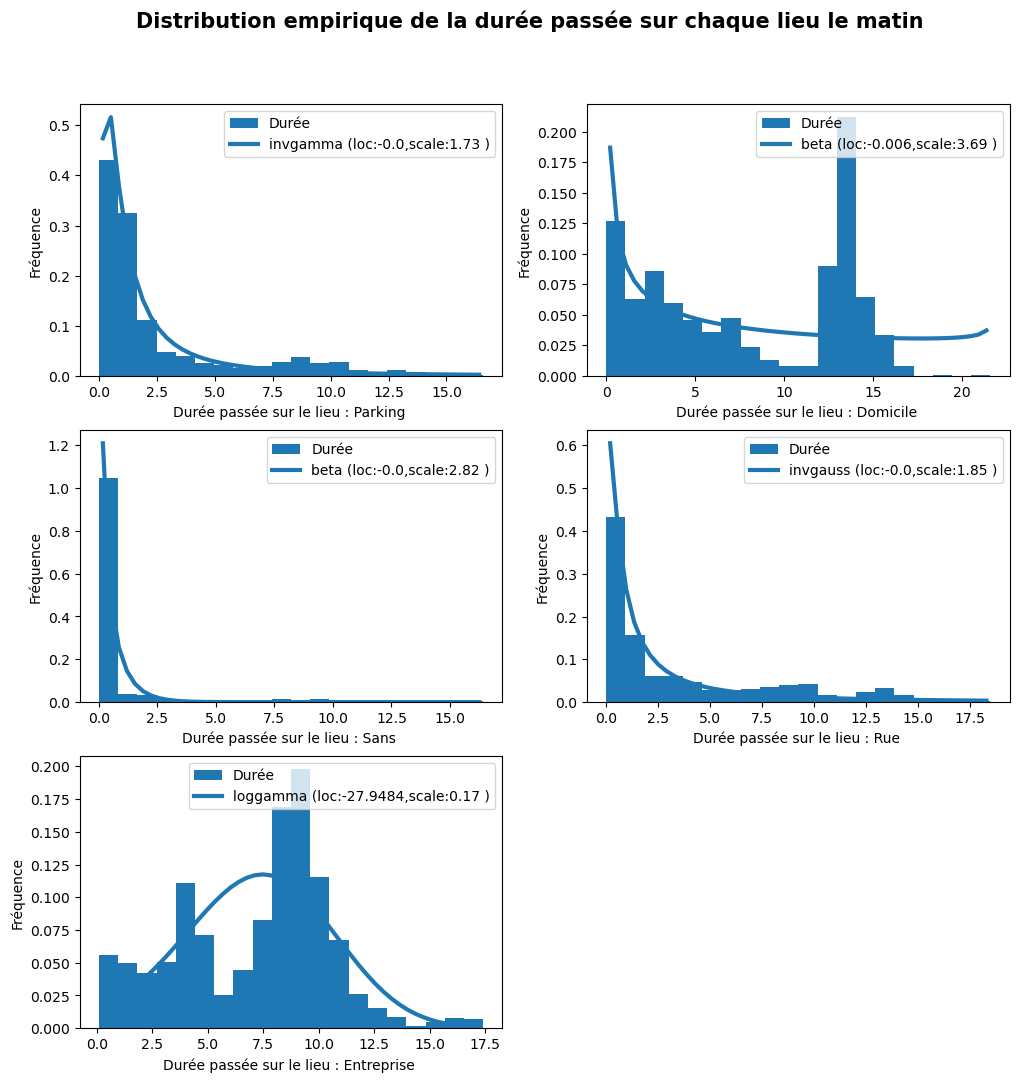

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_matin=[]

i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
    lois_duree_matin.append([best_name,param])
        
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le matin",va='center', fontweight="bold",fontsize=15,y=0.95)

In [68]:
lois_duree_matin

[['invgamma', (1.390737571634801, -9.772127964194171e-31, 1.7259786363251786)],
 ['beta', (2.1872413962120696, -0.005988001327689882, 3.6925482232686946)],
 ['beta', (1.218287798623423, -5.139663880520553e-31, 2.818723489330444)],
 ['invgauss',
  (1.3395802550303704, -1.7904907549755111e-28, 1.853609719131836)],
 ['loggamma', (200.9195815067319, -27.948438121633316, 0.17453264527549273)]]

In [69]:
emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"]

10       10.250000
28        8.750000
30        9.000000
32        9.333333
39        9.500000
           ...    
21098     8.500000
21124     0.666667
21148     3.666667
21196    13.750000
21202    10.250000
Name: Durée, Length: 1366, dtype: float64

In [70]:
emp_df[emp_df["Durée"].isnull()]

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée


In [71]:
emp_df[emp_df["IDENT_IND"]==930000611500001]

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée


/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le midi')

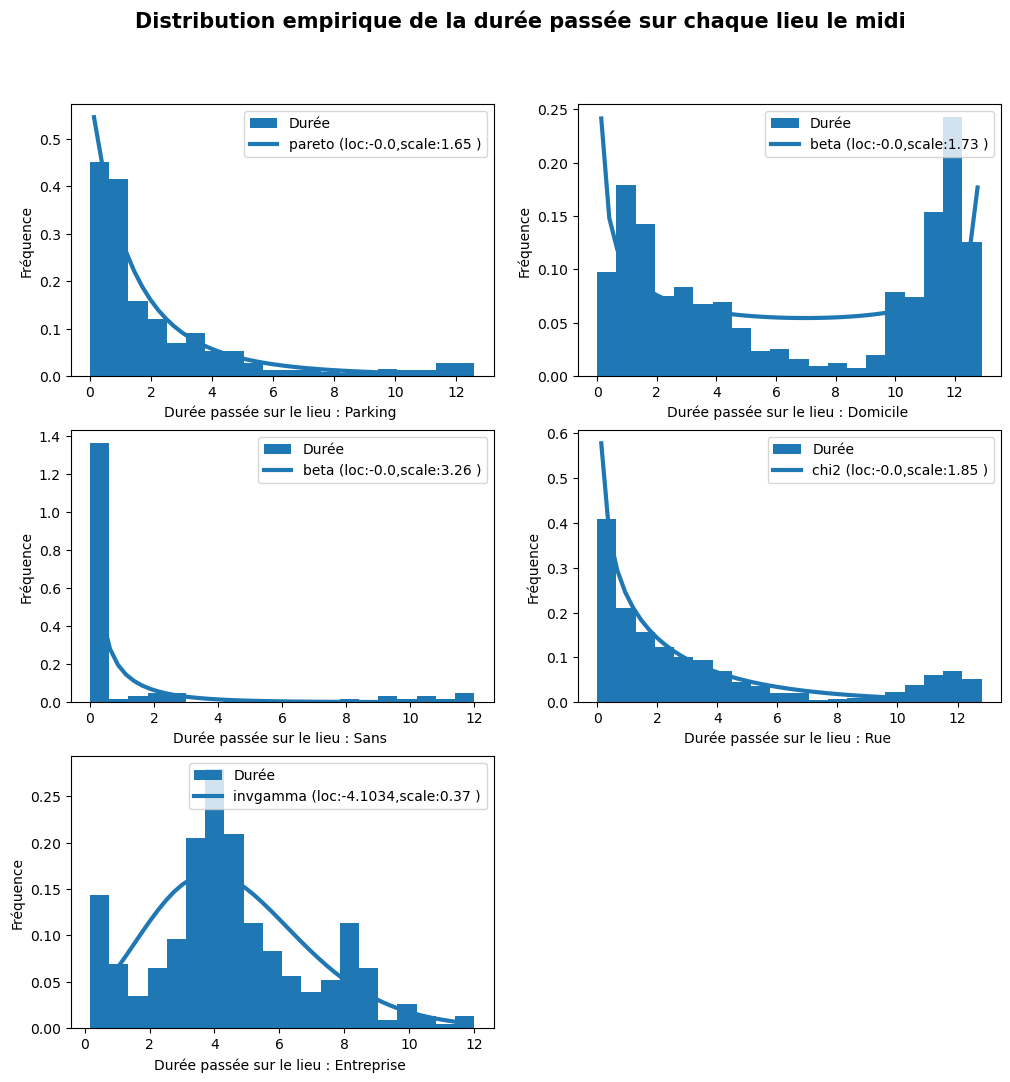

In [72]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_midi=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
    lois_duree_midi.append([best_name,param])    
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamb

Text(0.5, 0.95, "Distribution empirique de la durée passée sur chaque lieu l'après-midi")

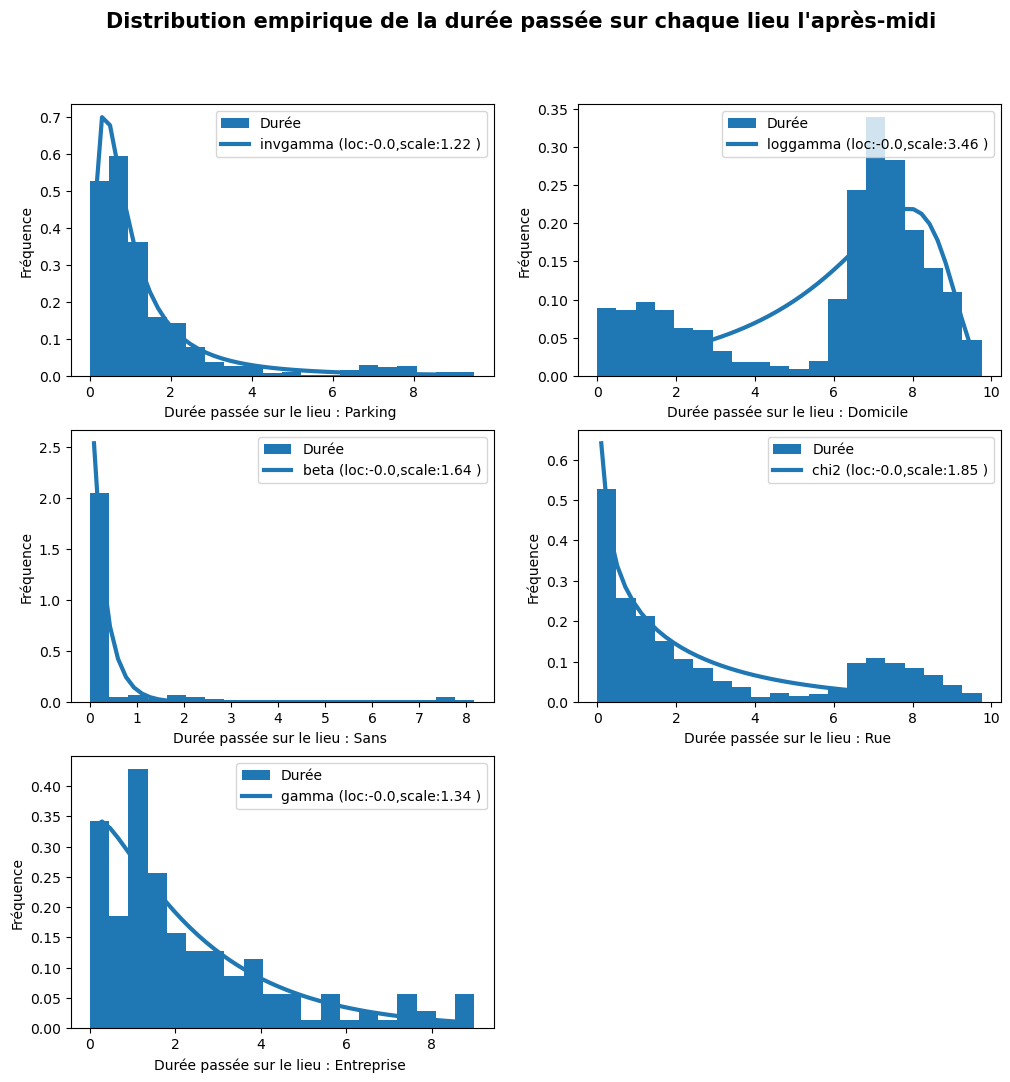

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_am=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
    
    lois_duree_am.append([best_name,param])		
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu l'après-midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le soir')

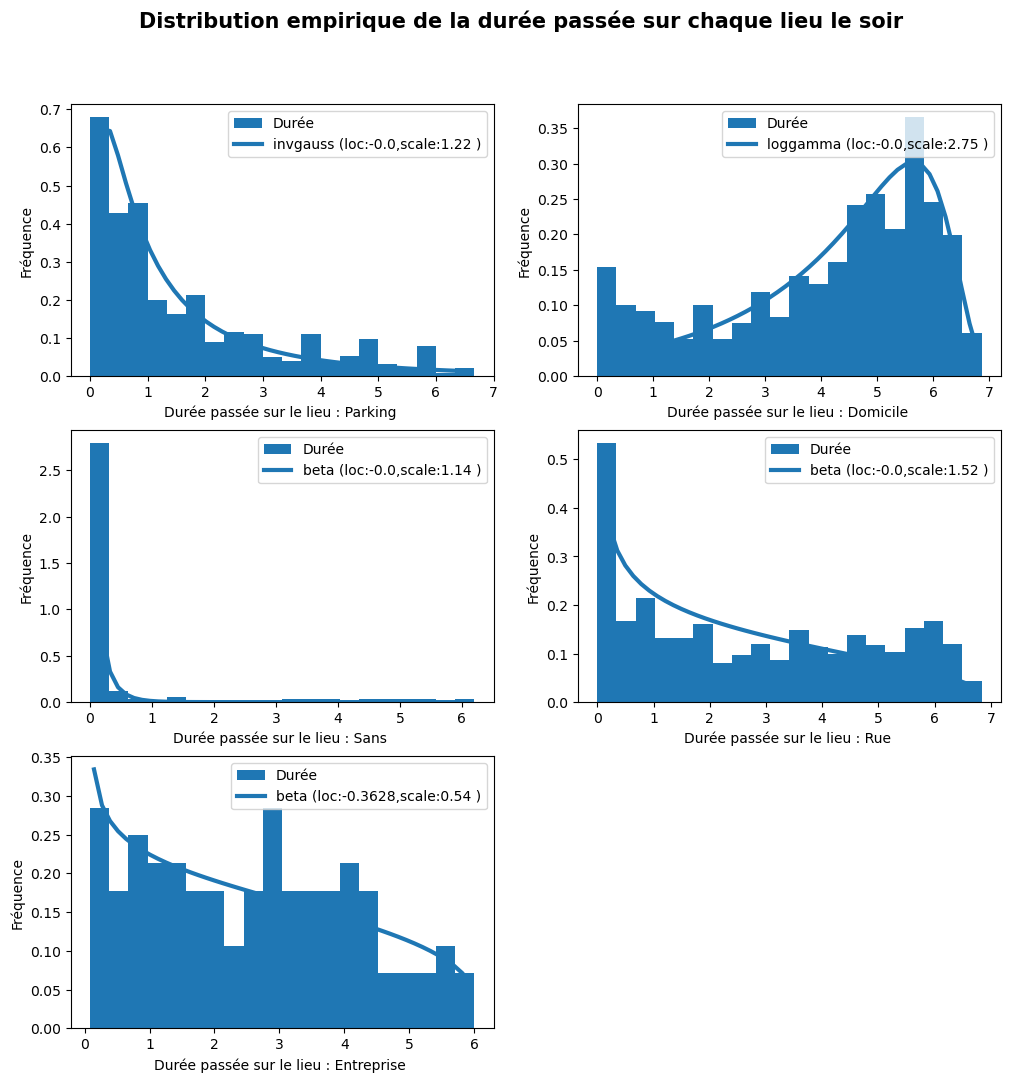

In [74]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_soir=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
    lois_duree_soir.append([best_name,param])    
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le soir",va='center', fontweight="bold",fontsize=15,y=0.95)

### Tableau des lois suivis pour la durée passée dans chaque lieu :

In [75]:
lois_duree_df=pd.DataFrame(index=["Matin","Midi","Après-midi","Soir"],columns=list(set(emp_df["Lieu_Arrivee"])))

In [76]:
lois_duree_df.loc["Matin"]=lois_duree_matin
lois_duree_df.loc["Midi"]=lois_duree_midi
lois_duree_df.loc["Après-midi"]=lois_duree_am
lois_duree_df.loc["Soir"]=lois_duree_soir

In [77]:
lois_duree_df

,Parking,Domicile,Sans,Rue,Entreprise
Matin,"[invgamma, (1.390737571634801, -9.772127964194...","[beta, (2.1872413962120696, -0.005988001327689...","[beta, (1.218287798623423, -5.139663880520553e...","[invgauss, (1.3395802550303704, -1.79049075497...","[loggamma, (200.9195815067319, -27.94843812163..."
Midi,"[pareto, (1.4013317752688952, -1.0965230799343...","[beta, (1.450000395484929, -2.2827792178756118...","[beta, (1.2651197309118647, -1.993472379916114...","[chi2, (1.3400808769713695, -5.127648667537803...","[invgamma, (23.59867259214333, -4.103398702392..."
Après-midi,"[invgamma, (1.512925644318115, -1.407890880051...","[loggamma, (1.9381474601884947, -3.29351895990...","[beta, (1.2182841162030988, -2.040599168036255...","[chi2, (1.3380657374339826, -2.022860775150514...","[gamma, (1.8472666355219776, -3.09093814367362..."
Soir,"[invgauss, (1.5202481297360722, -1.14193992426...","[loggamma, (1.6666258684844566, -4.05430486781...","[beta, (1.4241375370812803, -9.386663096812749...","[beta, (1.6969836415054367, -1.747498811137531...","[beta, (5.436846358958293, -0.3628406844398816..."


In [78]:
lois_duree_df.to_excel("data/lois_duree.xlsx")

In [43]:
h=(4,5,6)

In [45]:
h[-2]

5